Delete all variables in the current environment (if you have already run some cells) - clean state.

In [192]:
%reset

Import all necessary packages.

In [228]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import shutil
from datetime import datetime
from dateutil import parser
import json
from sklearn.cluster import KMeans
import math

Replace with the path to the root folder of the project.

In [194]:
rootdir_path = '/home/andreistoica12/research-internship'

Replace with the path to the folder where we store the dataset.

In [195]:
data_path = '/home/andreistoica12/research-internship/data/PhemeDataset'

IMPORTANT NOTE: After running the code, some files from the dataset will be different from the original versions, i.e. the "retweets.json" files inside each story folder were initially invalid. In order to consider and process the retweets in the longitudinal analysis, I formatted these files so that they are valid, parsable JSON files. If the file contained only one retweet object, it has not been modified. If the file contained multiple retweets, the file now contains a list of retweet objects, separated by a comma, as per the JSON syntax.

The paths to the folder containing all subfolders corresponding to each event of major interest (the Charlie Hebdo shooting, footballer Essien having Ebola, etc.). Tweets here are all written in English.

In [196]:
events_path = data_path + "/threads/en"

Create 2 subfolders to store important files and graphs, respectively. If they already existed (from previous runnings of the project), delete the folders and their contents and create empty folders to store the current files and graphs, relevant to the current state of the project.

In [197]:
files_path = os.path.join(rootdir_path, 'files')
if os.path.exists(files_path):
   shutil.rmtree(files_path, ignore_errors=False, onerror=None)
os.makedirs(files_path)

graphs_path = os.path.join(rootdir_path, 'graphs')
if os.path.exists(graphs_path):
   shutil.rmtree(graphs_path, ignore_errors=False, onerror=None)
os.makedirs(graphs_path)

In [198]:
pheme_graphs_path = os.path.join(graphs_path, 'pheme')
if os.path.exists(pheme_graphs_path):
   shutil.rmtree(pheme_graphs_path, ignore_errors=False, onerror=None)
os.makedirs(pheme_graphs_path)

Here, I define a function that first reads the JSON file and stores it into a dictionary, then parses the date contained at the "created_at" key. The number returned is an integer. 

In [199]:
def tweet_hour(tweet_path):
    with open(tweet_path) as f:
        tweet = json.load(f)
    date = parser.parse(tweet['created_at'])
    
    return date.hour

Function to return the source path, given the story path.

In [200]:
def source_tweet_path(story_path):
    source_dir_path = story_path + "/source-tweets"
    source_path = source_dir_path + "/" + os.listdir(source_dir_path)[0]
    
    return source_path

Function to return a list of all reactions' paths.

In [201]:
def reaction_tweets_paths(story_path):
    reactions_paths_list = []
    reactions_dir_path = story_path + "/reactions"
    for reaction_name in os.listdir(reactions_dir_path):
        reaction_path = reactions_dir_path + "/" + reaction_name
        reactions_paths_list.append(reaction_path)
        
    return reactions_paths_list

Function to validate whether a given JSON file is valid or not. Unmodified retweets files (the ones from teh original dataset) are not valid. We only want ot modify them when they are invalid, otherwise they will become invalid again, as we will have duplicate characters ("[[" / "]]" / ",,") .

In [202]:
def validateJSON(JSON_path):
    try:
        with open(JSON_path, 'r') as file:
            data = json.load(file)
    except ValueError as err:
        return False
    return True

Function to modify/format invalid JSON files for further processing.

In [203]:
def format_retweets_json(retweets_path):
    if not validateJSON(retweets_path):
        with open(retweets_path, 'r') as invalid_json:
            data = invalid_json.read()
        data = "[\n" + data.replace("}\n{", "},\n{") + "]"
        with open(retweets_path,'w') as valid_json:
            valid_json.write(data)

Function to return a list of the hours when all retweets of a specific story have been posted.

In [204]:
def hours_list_retweets(story_path):
    retweets_path = story_path + "/retweets.json"
    hours = []
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            hours = [ parser.parse(retweet['created_at']).hour for retweet in retweets_list ]
        else:   # we have this case when the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            hours = [parser.parse(retweets_list['created_at']).hour]

    return hours

I define a function to store all occurences of dates (only the hours) in a list.

In [205]:
def hours_list_story(story_path):
    # I create a list with all occurences of dates corresponding to the source tweet, reactions (replies) and retweets.
    hours = []

    # source hour
    source_path = source_tweet_path(story_path)
    hour = tweet_hour(source_path)
    hours.append(hour)

    # reactions hours
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        hour = tweet_hour(reaction_path)
        hours.append(hour)
    
    # retweets hours
    hours.extend(hours_list_retweets(story_path))
    
    return hours

Here, I define a function to return a pandas Series, representing the distribution of the hours of tweets (source tweets, reactions and retweets) posted regarding a specific event given as an input parameter. I chose to convert the list to a pandas Series due to the ease in creating a distribution and corresponding box plot.

In [206]:
def time_distribution_event(event_path):
    hours = []
    for story_id in os.listdir(event_path):
        story_path = event_path + "/" + story_id
        hours.extend(hours_list_story(story_path))
    hours.sort()
    hours_series = pd.Series(hours)
    distribution = hours_series.value_counts()[hours_series.unique()]
    
    return distribution

The following function is delegated to plot the distribution per hour of the tweets sent about a specific topic/event.

In [207]:
def plot_event_distribution(event_name, distribution):
    axes = distribution.plot(kind='bar')
    figure_path = "{pheme_graphs_path}/{event}_distribution.png".format(pheme_graphs_path = pheme_graphs_path, event = event_name)
    axes.figure.savefig(figure_path)
    plt.close()

Function to plot and save in the local graphs/ folder the distributions corresponding to all events.

In [208]:
def plot_all_event_distributions(events_path):
    for event in os.listdir(events_path):
        event_path = events_path + "/" + event
        distribution = time_distribution_event(event_path)
        plot_event_distribution(event, distribution)

In [209]:
plot_all_event_distributions(events_path)

Computing the reaction times to tweets

In [210]:
story_path = '/home/andreistoica12/research-internship/data/PhemeDataset/threads/en/ebola-essien/521346721226711040'

In [211]:
def deltas_in_minutes(story_path):
    deltas = []
    # Step 1: get t0 datetime object from the source timestamp
    source_path = source_tweet_path(story_path)
    with open(source_path) as file:
        source = json.load(file)
    t0 = parser.parse(source['created_at'])

    # Step 2: for all reactions, get the difference in minutes from the time the source was posted and the time each reaction was posted
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        with open(reaction_path) as file:
            reaction = json.load(file)
        deltas.append((parser.parse(reaction['created_at']) - t0).total_seconds() / 60)

    # Step 3: for all retweets, get the same time difference in miuntes as above
    retweets_path = story_path + "/retweets.json"
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            deltas.extend([ (parser.parse(retweet['created_at']) - t0).total_seconds() / 60 for retweet in retweets_list ])
        else:   # we have this case when the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            deltas.extend([ (parser.parse(retweets_list['created_at']) - t0).total_seconds() / 60 ])
    
    return deltas

In [212]:
deltas = deltas_in_minutes(story_path)

In [213]:
deltas

[21.716666666666665,
 84.63333333333334,
 40.416666666666664,
 13.55,
 82.13333333333334,
 71.25,
 23.666666666666668,
 98.61666666666666,
 99.41666666666667,
 17.166666666666668,
 22.966666666666665,
 26.666666666666668,
 82.61666666666666,
 25.033333333333335,
 23.9,
 88.28333333333333,
 10.783333333333333,
 84.16666666666667,
 19.983333333333334,
 77.28333333333333,
 78.16666666666667,
 14.883333333333333,
 77.08333333333333,
 10.5,
 37.86666666666667,
 36.55,
 439.56666666666666,
 789.75,
 850.3166666666667,
 9.566666666666666,
 9.6,
 9.8,
 9.8,
 9.833333333333334,
 9.883333333333333,
 9.9,
 9.933333333333334,
 9.966666666666667,
 10.0,
 10.0,
 10.1,
 10.15,
 10.216666666666667,
 10.216666666666667,
 10.316666666666666,
 10.316666666666666,
 10.333333333333334,
 10.433333333333334,
 10.45,
 10.55,
 10.65,
 10.666666666666666,
 10.716666666666667,
 10.783333333333333,
 10.8,
 10.85,
 10.866666666666667,
 10.883333333333333,
 10.933333333333334,
 10.95,
 10.966666666666667,
 11.05,
 

In [219]:
def elbow_method(deltas):
    wcss = []
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)
    for k in range(1, 11):  # loop over maximum 10 clusters, as this is a range where you usually find the optimum number of clusters
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
        kmeans.fit(deltas)
        wcss.append(kmeans.inertia_)

    # Plot the within-cluster sum of squares against the number of clusters
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show() 

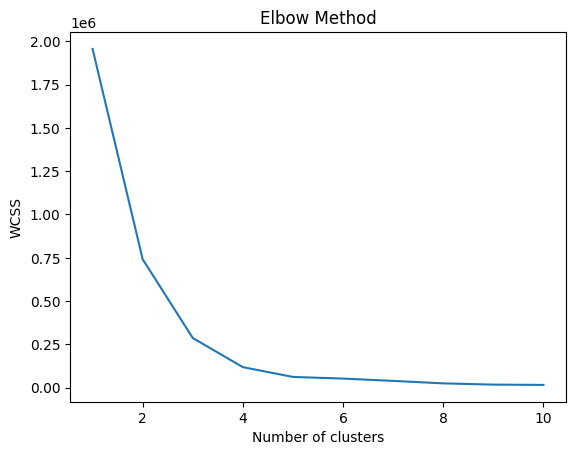

In [220]:
elbow_method(deltas)

In [221]:
# Define the number of clusters you want to create - look for the "elbow" point in the plot above,
#  where the rate of decrease in WCSS begins to level off
k = 4

In [222]:
def k_means_clustering(k, deltas):
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(deltas)

    # Get the labels assigned to each data point
    labels = kmeans.labels_

    # Get the centroids of each cluster
    centroids = kmeans.cluster_centers_

    # Print an overview of the resulting clusters
    for i in range(k):
        cluster_data = deltas[labels == i]
        print(f"Cluster {i+1} has {len(cluster_data)} data points and a centroid of {centroids[i][0]}")

    print("\nDeltas list - cluster label:\n")
    print(labels)

    # Create a dictionary to store the clustered data
    clusters_dict = {}
    for i, label in enumerate(kmeans.labels_):
        if label not in clusters_dict:
            clusters_dict[label] = [deltas[i][0]]
        else:
            clusters_dict[label].append(deltas[i][0])
    
    return clusters_dict

In [223]:
clusters_dict = k_means_clustering(k, deltas)

Cluster 1 has 53 data points and a centroid of 104.04371069182389
Cluster 2 has 2 data points and a centroid of 820.0333333333334
Cluster 3 has 145 data points and a centroid of 25.055977011494257
Cluster 4 has 6 data points and a centroid of 319.0361111111111

Deltas list - cluster label:

[2 0 2 2 0 0 2 0 0 2 2 2 0 2 2 0 2 0 2 0 0 2 0 2 2 2 3 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3]


In [229]:
def plot_story_reaction_times(story_name, clusters_dict):
    clusters_plot_dict = {}
    for key, value in clusters_dict.items():
        clusters_plot_dict[f"{math.floor(min(value))} - {math.ceil(max(value))}"] = len(value)
    
    intervals = list(clusters_plot_dict.keys())
    values = list(clusters_plot_dict.values())

    plt.bar(range(len(clusters_plot_dict)), values, tick_label=intervals)
    plt.title('Distribution of reaction times in minutes')
    plt.xlabel('Reaction times (between x and y minutes)')
    plt.ylabel('Number of reactions')
    plt.show()

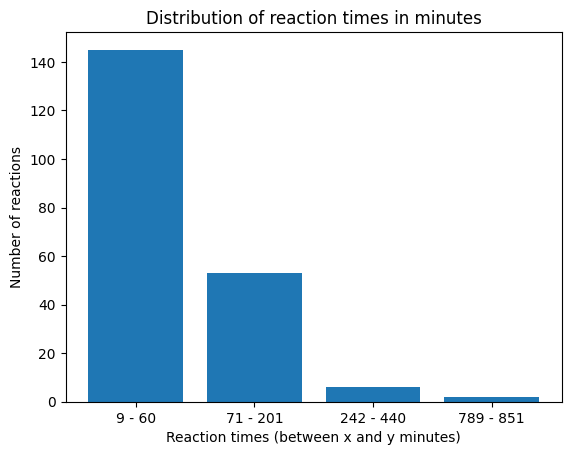

In [230]:
plot_story_reaction_times('ebola_first_story', clusters_dict)